# Mel-frequency cepstral coefficients algorithm implementation from scratch

#### Based on https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html 

In [6]:
import os
import glob
import numpy as np
import librosa
import librosa.display
import scipy
import scipy.fftpack as fft
from scipy.fftpack import dct
from scipy.signal import get_window
import matplotlib.pyplot as plt

%matplotlib inline

Tensorflow [data-speech-commands database](https://storage.cloud.google.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz)

In [7]:
# Getting sample to test the MFCC function
audio, sample_rate = librosa.load('/home/joao/Desktop/datasets/data_speech_commands_v0.02/cat/' + 'ffd2ba2f_nohash_0.wav')
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 22050Hz
Audio duration: 1.0s


## MFCC function

In [8]:
# Define MFCC function
def jb_mfcc(audio,
            sample_rate,
            n_mfcc=13,
            lifter=22,
            frame_size=0.025,
            frame_stride=0.01, 
            NFFT = 512
            ):
    # Pre-emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])
    # Framing
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    # Windowing
    # After slicing the signal into frames, we apply a window function such as the Hamming window to each frame.
    n = np.arange(frame_length)
    frames *= 0.54-0.46*np.cos((2*np.pi*n)/(frame_length-1))
    # STFT
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    # Filter banks
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    # MFCC
    num_ceps = n_mfcc
    cep_lifter = lifter # original used 22
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift  #*
    #Normalizing
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    
    return mfcc

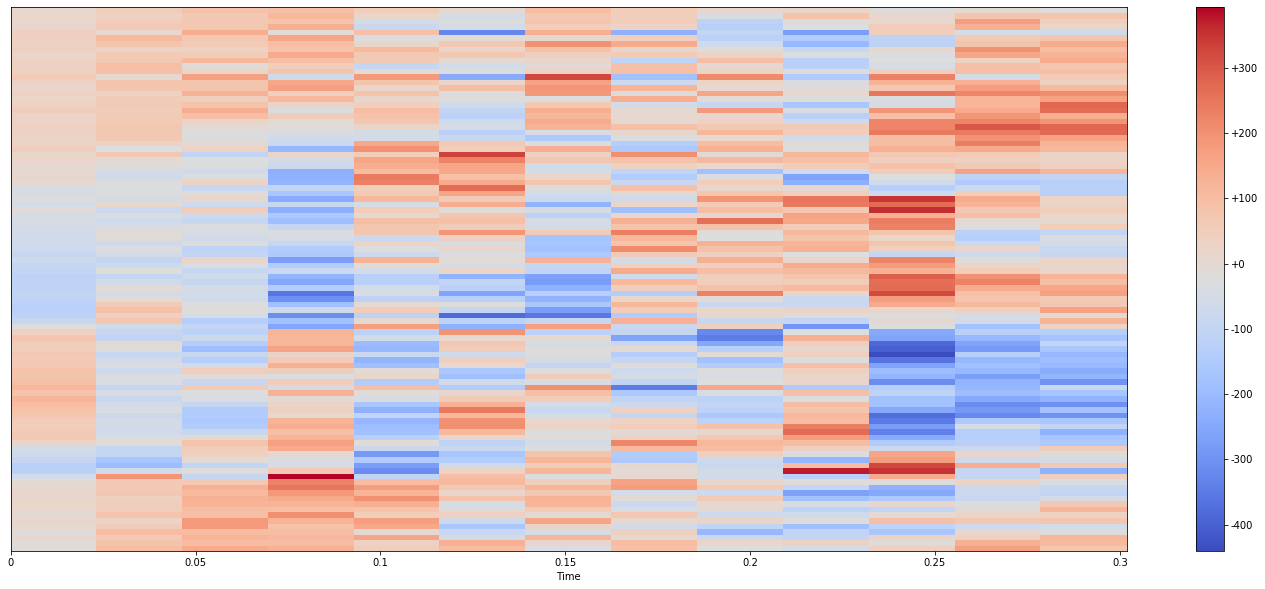

In [9]:
mfcc = jb_mfcc(audio, sample_rate, n_mfcc=13)
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfcc, 
                         x_axis="time", 
                         sr=sample_rate)
plt.colorbar(format="%+2.f")
plt.show()